In [5]:
import pandas as pd
import prophet as pr
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
%cd -q ../..
from utils import util
from utils import executor
from utils import metrics
%cd -q -

In [8]:
manager=executor.GasModelManager()
slots=manager.get_slots()
df_gesamt=manager.df_gesamt[0:365*2]

In [9]:
fold=0
target='ENTRY'
#start='2012-05-01'

In [10]:
def format_df(df,target):
    df['ds']=df.index
    df['y']=df[target]
    return df

In [11]:
df_mod=format_df(df_gesamt,target)

In [12]:
def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month > 11 or date.month < 2)

df_mod['winter_season'] = df_mod['ds'].apply(is_winter)
df_mod['summer_season'] = ~df_mod['ds'].apply(is_winter)

In [13]:
def init_prophet():

    changepoint_prior_scale = 0.01 # Decreasing it will make the trend less flexible, DEFAULT=0.05
    seasonality_prior_scale=10 #large value allows the seasonality to fit large fluctuations [0.01, 10], DEFAULT=10
    holidays_prior_scale=10 #[0.01, 10] DEFAULT=10
    monthly_prior_scale=20
    seasonality_mode='additive' # DEFAULT='additive'

    yearly_seasonality_s=10 #increased when the seasonality needs to fit higher-frequency changes, DEFAULT=10
    weekly_seasonality=10
    monthly_seasonality=10
    mcmc_samples=0 # uncertainty in seasonality, you must do full Bayesian sampling, DEFAULT=0
    growth='linear' # DEFAULT='linear'

    extra_prior=10
    extra_seasonality=60

    #m=pr.Prophet(yearly_seasonality=True,growth='linear')
    m=pr.Prophet(yearly_seasonality=yearly_seasonality_s,weekly_seasonality=weekly_seasonality,growth=growth, changepoint_prior_scale=changepoint_prior_scale,holidays_prior_scale=holidays_prior_scale,seasonality_prior_scale=seasonality_prior_scale,seasonality_mode=seasonality_mode, mcmc_samples=mcmc_samples)

    m.add_seasonality(name='monthly', period=30.5, fourier_order=monthly_seasonality,mode=seasonality_mode, prior_scale=monthly_prior_scale)

    m.add_regressor('SLP',prior_scale=5,mode='additive')

    for i in ['tavg_mean', 'tavg_std', 'tmin_mean','tmin_std', 'tmax_mean', 'tmax_std', 'prcp_mean', 'prcp_std','snow_mean', 'snow_std', 'wdir_mean', 'wdir_std', 'wspd_mean','wspd_std', 'wpgt_mean', 'wpgt_std', 'pres_mean', 'pres_std','tsun_mean', 'tsun_std']:
        m.add_regressor(i,prior_scale=1,mode='multiplicative')

    #m.add_seasonality(name='winter_season', period=7, fourier_order=extra_seasonality,mode=seasonality_mode, prior_scale=extra_prior, condition_name='winter_season')
    #m.add_seasonality(name='summer_season', period=30.5, fourier_order=extra_seasonality,mode=seasonality_mode, prior_scale=extra_prior, condition_name='summer_season')

    m.add_country_holidays(country_name='DE')
    return m

In [14]:
make_imputation=True

imputed=[]
past=[]

#k=2
k=len(slots)

if make_imputation is True:
    for i in range(k):
        train_df=format_df(manager.get_train(i),target)
        m=init_prophet()
        m.fit(train_df)

        past.append(m.predict())

        future=format_df(manager.get_forecast(i, 0),target)

        imputed.append(m.predict(future[['ds','SLP','tavg_mean', 'tavg_std', 'tmin_mean','tmin_std', 'tmax_mean', 'tmax_std', 'prcp_mean', 'prcp_std','snow_mean', 'snow_std', 'wdir_mean', 'wdir_std', 'wspd_mean','wspd_std', 'wpgt_mean', 'wpgt_std', 'pres_mean', 'pres_std','tsun_mean', 'tsun_std']]))

Train dates are from "2011-10-01 00:00:00" to "2012-10-24 00:00:00", 390 elements


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train dates are from "2011-10-01 00:00:00" to "2012-11-23 00:00:00", 420 elements


In [15]:
rlm_imputed=None
for i in imputed:
    if rlm_imputed is None:
        rlm_imputed=i
    else:
        rlm_imputed=pd.concat([rlm_imputed,i])

In [16]:
rlm_imputed2=None

for i in range(len(past)):
    if rlm_imputed2 is None:
        rlm_imputed2=past[i]
    else:
        tmp=past[i]
        rlm_imputed2=pd.concat([rlm_imputed2,tmp[tmp['ds']>rlm_imputed2.iloc[-1]['ds']]])


0.025998084260811145


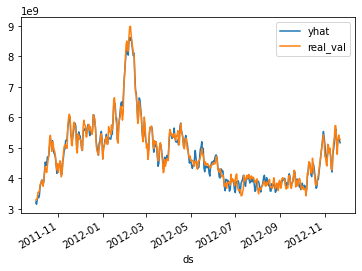

In [17]:
if make_imputation is True:
    rlm_complete=pd.concat([rlm_imputed,rlm_imputed2]).reset_index(drop=True).sort_values('ds')
    rlm_complete.index=rlm_complete['ds']
    rlm_complete.drop('ds',axis=1,inplace=True)

    rlm_complete2=rlm_complete.copy()
    rlm_complete2['real_val']=manager.df_gesamt[manager.df_gesamt.index<=rlm_complete.index[-1:][0]][target]
    rlm_complete2=rlm_complete2.dropna()

    print(metrics.METRICS_REGRESSION['mape'](rlm_complete2['real_val'],rlm_complete2['yhat']))
    rlm_complete2.plot(use_index=True,y=['yhat','real_val'])

# Write out imputation

In [18]:
#rlm_imputed.to_csv('./'+target+'_imputation.csv',sep=';')
#rlm_complete.to_csv('./'+target+'_imputation.csv',sep=';')

In [19]:
#rlm_imputed.head()